In [6]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy.stats import beta

In [2]:
referrals = pd.read_csv('../../Welcome-Centre-DataCorps-Data/referrals.csv')

/Users/davidsykes/anaconda/envs/data-analysis/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (44,46,47,51) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
referrals['ReferralTakenDate'] = pd.to_datetime(referrals['ReferralTakenDate'])

In [4]:
days_active = (referrals['ReferralTakenDate'].max() - referrals.groupby('ClientId')['ReferralTakenDate'].min()).dt.days + 7

In [74]:
np.histogram(np.array([1,2,3,4]), bins=[0,2,5])

(array([1, 3]), array([0, 2, 5]))

/Users/davidsykes/anaconda/envs/data-analysis/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:404: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*sqrt(a + b + 1) / (a + b + 2) / sqrt(a*b)
/Users/davidsykes/anaconda/envs/data-analysis/lib/python3.5/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


0.673043695209 97.1200611527
5376


(array([ 0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,
         0.45,  0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,
         0.9 ,  0.95,  1.  ]), 1.0)

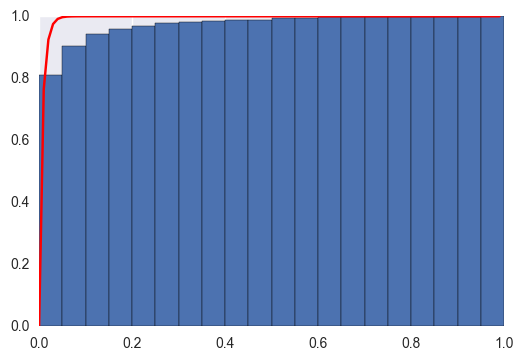

In [101]:
def get_score(referrals, break_length=28, break_coefficient=1, min_beta_fit_days=365):
    gaps = (referrals.sort_values('ReferralTakenDate').groupby('ClientId')['ReferralTakenDate'].diff().dt.days > break_length).groupby(referrals['ClientId']).sum()
    days_active = (referrals['ReferralTakenDate'].max() - referrals.groupby('ClientId')['ReferralTakenDate'].min()).dt.days + 7
    weeks_active = days_active / 7
    referrals = (referrals.groupby('ClientId').size())
    simple_ratio = (referrals - gaps) / weeks_active
    a, b, loc, scale = beta.fit((simple_ratio[days_active > min_beta_fit_days]).values)
    adjusted_ratio = ((referrals - gaps * break_coefficient + a) / (weeks_active + a + b)).sort_values()
    score_df = pd.concat([referrals, gaps, weeks_active, simple_ratio, adjusted_ratio], axis=1)
    score_df.columns=['Referrals', 'Gaps', 'Weeks Active', 'Simple Ratio', 'Empirical Bayes Ratio']
    return score_df.sort_values('Empirical Bayes Ratio')

def plot_beta(referrals, break_length=28, break_coefficient=1, min_beta_fit_days=365):
    gaps = (referrals.sort_values('ReferralTakenDate').groupby('ClientId')['ReferralTakenDate'].diff().dt.days > break_length).groupby(referrals['ClientId']).sum()
    days_active = (referrals['ReferralTakenDate'].max() - referrals.groupby('ClientId')['ReferralTakenDate'].min()).dt.days + 7
    weeks_active = days_active / 7
    referrals = (referrals.groupby('ClientId').size())
    simple_ratio = (referrals - gaps) / weeks_active
    a, b, loc, scale = beta.fit((simple_ratio[days_active > min_beta_fit_days]).values)
#     a=0.5
#     b=15
    print(a,b)
    print(len(simple_ratio))
    hist, bin_edges = np.histogram(simple_ratio, bins=np.arange(0,1.01,0.05))
    normed_hist = hist/hist.sum()
    cum_normed_hist = normed_hist.cumsum()
    f, ax = plt.subplots()
    plot_range = np.arange(0,1,0.01)
    beta_cdf = beta.cdf(plot_range, a, b)
    ax.bar(bin_edges[:-1], cum_normed_hist, width=(bin_edges[1]-bin_edges[0]))
    plt.plot(plot_range, beta_cdf, color='red')
    return bin_edges, normed_hist.sum()
plot_beta(referrals)

In [ ]:
beta.pdf([])

In [21]:
beta.pdf([0.001, 0.5, 0.999], 0.67, 97)

array([  1.40985269e+002,   2.51969040e-028,   1.58865742e-287])

In [58]:
scores = get_score(referrals)
for_tableau = referrals.merge(scores, left_on='ClientId', right_index=True)
for_tableau.to_clipboard()

/Users/davidsykes/anaconda/envs/data-analysis/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:404: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*sqrt(a + b + 1) / (a + b + 2) / sqrt(a*b)
/Users/davidsykes/anaconda/envs/data-analysis/lib/python3.5/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [56]:
for_tableau.head()

,ReferralInstanceId,StatusId,ReferralOnHold,ReferralTakenDate,ReferralReadyDate,ReferralCollectedDate,ReferralWorkerID,ReferralPreparedWorkerId,ReferralHandedWorkerId,ClientId,...,ReferralIssue_Refugee,ReferralIssue_Street Homeless,ReferralIssue_Street worker,ReferralIssue_fleeing domestic violence,ReferralIssue_meltham food service delivery,Referrals,Gaps,Weeks Active,Simple Ratio,Empirical Bayes Ratio
0,1,3,0,2014-01-28 00:00:00,01/28/14 00:00:00,01/28/14 00:00:00,4,NaN,NaN,2,...,NaN,NaN,NaN,NaN,NaN,7,1.0,168.0,0.035714,0.025106
1,2,3,0,2014-03-07 00:00:00,03/07/14 00:00:00,03/07/14 00:00:00,4,NaN,NaN,2,...,NaN,NaN,NaN,NaN,NaN,7,1.0,168.0,0.035714,0.025106
2,3,3,0,2014-03-21 00:00:00,03/21/14 00:00:00,03/21/14 00:00:00,4,NaN,NaN,2,...,NaN,NaN,NaN,NaN,NaN,7,1.0,168.0,0.035714,0.025106
1860,1671,3,0,2014-04-04 14:45:00,04/04/14 14:45:00,04/04/14 14:45:00,4,4.0,4.0,2,...,NaN,NaN,NaN,NaN,NaN,7,1.0,168.0,0.035714,0.025106
1986,1797,3,0,2014-04-11 16:12:00,04/11/14 16:13:00,04/11/14 16:13:00,7,7.0,7.0,2,...,NaN,NaN,NaN,NaN,NaN,7,1.0,168.0,0.035714,0.025106


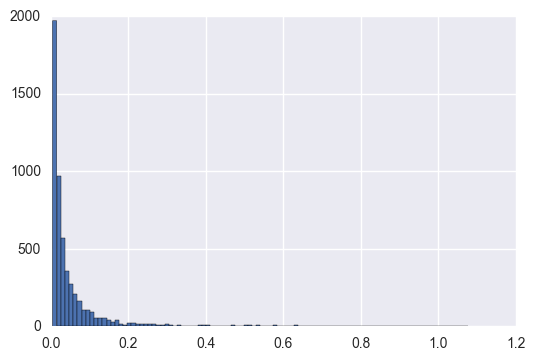

In [57]:
simple_ratio = ((referrals.groupby('ClientId').size()) / (days_active / 7))
simple_ratio[simple_ratio < np.inf].hist(bins=100)

In [6]:
from scipy.stats import beta

In [7]:
beta.fit((simple_ratio[days_active > 365]).values)

/Users/jamesgin/.virtualenvs/datasine/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:412: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Users/jamesgin/.virtualenvs/datasine/lib/python3.5/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


(0.62793143715979771,
 950.0625965965985,
 -2.2106289025932894e-28,
 10.374297748073433)

In [8]:
adjusted_ratio = ((referrals.groupby('ClientId').size() - 1 + 0.6279) / ((days_active / 7) + 950)).sort_values()

In [9]:
df = pd.concat([referrals.groupby('ClientId').size(), days_active / 7, simple_ratio, adjusted_ratio], axis=1)
df.columns=['count', 'weeks available', 'simple ratio', 'bayes ratio']
df.to_csv('test_ranking.csv')

In [12]:
df.sort_values('bayes ratio')

,count,weeks available,simple ratio,bayes ratio
ClientId,,,,
461,1,217.857143,0.000000,0.000538
603,1,217.857143,0.000000,0.000538
228,1,217.714286,0.000000,0.000538
51,1,217.714286,0.000000,0.000538
721,1,217.714286,0.000000,0.000538
939,1,217.714286,0.000000,0.000538
781,1,217.714286,0.000000,0.000538
841,1,217.714286,0.000000,0.000538
540,1,171.714286,0.000000,0.000560


In [10]:
test = referrals[referrals['ClientId'] == 2890].sort_values('ReferralTakenDate')
test

,ReferralInstanceId,StatusId,ReferralOnHold,ReferralTakenDate,ReferralReadyDate,ReferralCollectedDate,ReferralWorkerID,ReferralPreparedWorkerId,ReferralHandedWorkerId,ClientId,...,ReferralDietaryRequirements_Diabetic,ReferralDietaryRequirements_Gluten Intolerant/coeliac,ReferralDietaryRequirements_Halal,ReferralDietaryRequirements_No Pork,ReferralDietaryRequirements_Nut Allergy,ReferralDietaryRequirements_Other Dietary Requirement,ReferralDietaryRequirements_Vegan,ReferralDietaryRequirements_Vegetarian,ReferralDietaryRequirements_lactose intolerent,ReferralDietaryRequirements_pregnancy
3917,3865,3,0,2014-09-02 10:37:00,09/02/14 16:48:00,09/02/14 16:48:00,5,1.0,1.0,2890,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5741,5555,3,0,2014-12-22 10:26:00,12/22/14 17:28:00,12/22/14 17:28:00,5,1.0,1.0,2890,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5914,5728,3,0,2015-01-06 14:11:00,01/06/15 17:09:00,01/06/15 17:09:00,6,1.0,1.0,2890,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6023,5837,3,0,2015-01-13 14:40:00,01/13/15 16:50:00,01/13/15 16:50:00,1,1.0,1.0,2890,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6135,5949,3,0,2015-01-20 13:05:00,01/20/15 15:58:00,01/20/15 15:58:00,1,1.0,1.0,2890,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6227,6041,3,0,2015-01-27 12:46:00,01/27/15 13:46:00,01/27/15 13:46:00,1,5.0,5.0,2890,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6472,6286,3,0,2015-02-10 15:32:00,02/10/15 15:43:00,02/10/15 15:43:00,5,5.0,5.0,2890,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6662,6476,3,0,2015-02-24 12:57:00,02/24/15 14:14:00,02/24/15 14:14:00,5,5.0,5.0,2890,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6774,6588,3,0,2015-03-03 13:03:00,03/03/15 14:22:00,03/03/15 14:22:00,5,5.0,5.0,2890,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6868,6682,3,0,2015-03-10 12:55:00,03/10/15 13:58:00,03/10/15 13:58:00,6,5.0,5.0,2890,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
rest_days = 28
days = (test['ReferralTakenDate'] - test['ReferralTakenDate'].min()).dt.days
days.diff()

In [ ]:
def get_burst_number(group, rest_days):
    days = (group['ReferralTakenDate'] - group['ReferralTakenDate'].min()).dt.days
    same_burst = (days.diff() < rest_days)
    burst_number = (((same_burst != same_burst.shift(1)) & ~same_burst) | ~same_burst).cumsum()
    return burst_number

In [ ]:
def add_burst_numbers(referrals, rest_days=28):
    referrals = referrals.sort_values('ReferralTakenDate')
    burst_number = referrals.groupby(referrals['ClientId']).apply(get_burst_number, rest_days)
#     return burst_number
    referrals['burst_number'] = burst_number.reset_index().set_index('level_1')['ReferralTakenDate']
    return referrals

In [ ]:
burst_number = add_burst_numbers(referrals,28)

In [ ]:
burst_number[referrals['ClientId'] == 594]['burst_number']

In [ ]:
burst_number.to_csv('with_burst_number.csv')

In [ ]:
burst_number.groupby(['ClientId', 'burst_number']).size().reset_index().groupby(['ClientId']).size().idxmax()